In [396]:
import pandas as pd
import numpy as np
from scipy import optimize
import seaborn as sns; sns.set(); 
%matplotlib inline

## Import Data

In [397]:
sam_df = pd.read_csv('../data/sam/state_sams/Alabama_2015.csv', index_col = 0)

# Sort columns and index
sam_df = sam_df.reindex(sorted(sam_df.columns), axis=1).reindex(sorted(sam_df.index), axis=0)

## Function Input

In [398]:
# Generate matrix from sam
sam_mat = np.matrix(sam_df)

In [399]:
sam_df.sum(axis = 0)[sam_df.sum(axis = 0) == 0]

sam_df.sum(axis = 0)[sam_df.sum(axis = 1) == 0]

np.round(sam_df.sum(axis = 0) - sam_df.sum(axis = 1), 2)

AGR_CRP         -8.88
AGR_LIV         82.35
BIOMASS          0.00
CAP              2.23
CORP             0.00
ELC_BECCS        0.00
ELC_BIOMASS     89.71
ELC_DIST        25.28
ELC_FF          -0.14
ELC_GEO          0.00
ELC_HYDRO      -14.44
ELC_NUC        -66.26
ELC_OTHER       -1.29
ELC_RNW          0.00
ELC_SOLAR        0.00
ELC_WIND         0.00
FORE           -84.31
GOV_FED         28.20
GOV_FED_EMP      0.00
GOV_FED_ENT     41.84
GOV_STT        663.00
GOV_STT_EMP      0.00
GOV_STT_ENT     81.81
HOH             -0.00
LAB            -10.85
MAN              0.86
NonIndustry      0.00
PAP              1.55
PROF            -0.00
PROP           -13.95
SER             -0.00
TAX           -816.66
TRD             -0.00
dtype: float64

In [400]:
# # Random matrix for testing
# temp = np.matrix(np.random.random((4,4)))*1.2
# sam_mat_true = np.round(temp + temp.T, 0).astype(int)
# sam_mat = sam_mat_true + np.round(np.matrix(np.random.random((10,10)))*3.2, 0)
# sam_mat[:,1] = 0
# sam_mat[1,:] = 0
# sam_mat 

In [401]:
# Column sums
y = np.sum(sam_mat, axis = 0).T

# Coefficient matrix
A = np.divide(sam_mat, y.T, where = (y.T != 0))
A[:, np.where(y.T == 0)[1]] = 0
A_original = A.copy()

n = np.shape(A)[0]

## Objectives and Constrains

In [510]:
def kl_divergence(mat_b):
    mat_a = A_original
    mat_b = np.matrix(np.reshape(mat_b, (n,n)))
    
    # Divide matrices where we don't have zeros
    mat_div = np.divide(mat_b, mat_a, where = ((mat_a*100).astype(int) != 0))
    
    # Replace 0's with 1's which will become 0's when logged
    mat_div[np.where((mat_a*100).astype(int) == 0)] = 1
    mat_div[mat_div == 0] = 1
    
    return np.sum(np.multiply(mat_b, np.log(mat_div)))

def row_col_constraint(A):    
    A = np.matrix(np.reshape(A, (n,n)))
    sam = np.multiply(A, y.T)
    return np.sum(np.square(np.sum(sam, axis = 0).T - np.sum(sam, axis = 1)))

def coeff_constraint(A):
    A = np.matrix(np.reshape(A, (n,n)))
    
    # Get squared differences from A column sums and 1 
    sq_error = np.array(np.square(np.sum(A, axis = 0) - 1)).flatten()
    
    # Ignore error terms where A is 0 (indicates 0 row/col in SAM)
    sq_error[np.where(np.sum(A, axis = 0) == 0)[1]] = 0
    
    return np.sum(sq_error)

## Initial Guess - RAS Method

In [511]:
sam_mat_temp = sam_mat.copy()

In [512]:
track_list  = []

# Average absolute error of row column differences on which to break
break_value = 1 

for t in range(20):

    div_differences = np.divide(target_sum, sam_mat_temp.sum(axis = 0), where = (sam_mat_temp.sum(axis = 0) != 0))
    sam_mat_temp    = np.dot(sam_mat_temp, np.diag(np.array(div_differences).flatten()))

    div_differences = np.divide(target_sum.T, sam_mat_temp.sum(axis = 1), where = (sam_mat_temp.sum(axis = 1) != 0))
    sam_mat_temp    = np.dot(sam_mat_temp.T, np.diag(np.array(div_differences).flatten()).T).T              
    
    sam_mat_temp[2,6] = sam_mat_temp[:,2].sum()
    
    avg_abs_diff = (np.mean(np.abs(np.add(sam_mat_temp.sum(axis = 0).T, -sam_mat_temp.sum(axis = 1)))))
    track_list.append([t, avg_abs_diff])
    
    if avg_abs_diff < 1:
        break

In [513]:
np.sum(np.square(np.add(sam_mat_temp.sum(axis = 0).T, -sam_mat_temp.sum(axis = 1))))

118.12910972986266

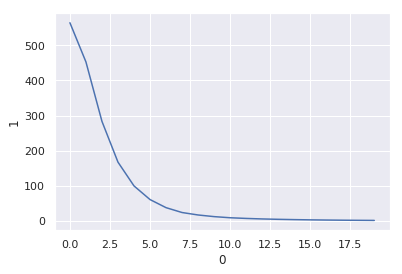

In [514]:
sns.lineplot(x = 0, y = 1, data = pd.DataFrame(track_list))

In [515]:
track_list[-1]

[19, 0.9940570572881158]

In [516]:
## Matrix for initial guess
# Coefficient matrix
A_temp = np.divide(sam_mat_temp, y.T, where = (y.T != 0))
A_temp[:, np.where(y.T == 0)[1]] = 0

In [517]:
print(coeff_constraint(A_temp))
print(row_col_constraint(A_temp))

5015.4939514809785
118.1291097297958


In [486]:
sam_df.head()

,AGR_CRP,AGR_LIV,BIOMASS,CAP,CORP,ELC_BECCS,ELC_BIOMASS,ELC_DIST,ELC_FF,ELC_GEO,...,HOH,LAB,MAN,NonIndustry,PAP,PROF,PROP,SER,TAX,TRD
AGR_CRP,18.280,28.046,7.942,4.794,0.000,0.0,0.000,0.0,0.00,0.0,...,69.165,0.0,382.341,0.0,0.000,0.0,0.000,13.058,0.0,804.935
AGR_LIV,14.123,440.701,16.982,4.477,0.000,0.0,0.000,0.0,0.00,0.0,...,92.691,0.0,2086.673,0.0,0.000,0.0,0.000,9.425,0.0,1872.766
BIOMASS,0.000,0.000,0.000,0.000,0.000,0.0,108.393,0.0,0.00,0.0,...,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
CAP,0.000,2.927,0.000,1122.181,6144.526,0.0,2.217,0.0,1.29,0.0,...,11695.610,0.0,163.343,0.0,21.109,0.0,31808.854,69.420,0.0,45465.664
CORP,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.00,0.0,...,0.000,0.0,0.000,0.0,0.000,0.0,23098.129,0.000,0.0,0.000


In [518]:
np.divide(np.sum(sam_mat_temp, axis = 1).T, np.sum(sam_mat_temp, axis = 0), where = np.sum(sam_mat_temp, axis = 0) != 0)

matrix([[0.99998, 0.99999, 1.     , 1.00002, 1.00003, 0.     , 0.99944,
         0.99998, 0.99998, 0.     , 0.99998, 0.99998, 0.99997, 1.00001,
         0.     , 0.     , 0.99998, 1.00003, 0.99996, 1.     , 1.00002,
         0.99997, 0.99999, 1.     , 1.00004, 0.99998, 0.     , 0.99998,
         1.00004, 1.00003, 0.99998, 1.00002, 1.00002]])

In [503]:
np.sum(np.square(np.sum(sam_mat_temp, axis = 1).T - np.sum(sam_mat_temp, axis = 0)))

118.12910972986266

## Optimize

### Direct row/col min of SAM

In [175]:
np.divide(A.sum(axis = 0), A.sum(axis = 1).T, where = A.sum(axis = 1).T != 0) - 1

matrix([[ 7.46209149e+00,  2.45462020e+00,  2.46070537e-02,
         -2.51342645e-03,  2.08584877e+00, -1.00000000e+00,
          3.93646645e+00,  8.49341564e+00,  1.23915841e+00,
         -1.00000000e+00,  6.38988421e+00,  4.22469041e-01,
          1.21701853e+02,  1.02002238e+01, -1.00000000e+00,
         -1.00000000e+00,  3.64228496e-02,  4.08989707e-02,
          4.05298032e+00,  1.54045825e+01, -1.04024376e-01,
          1.20761194e+00,  6.29457503e+00, -7.06957346e-01,
         -7.46263179e-01, -4.13541453e-01, -1.00000000e+00,
          1.45486190e+01,  3.13621413e-02, -6.15198373e-01,
         -5.97651216e-01,  2.70548901e+00, -7.65384831e-01]])

In [224]:
def row_col_diff(A):
    A = np.matrix(np.reshape(A, (n,n)))
    return np.sum(np.square(np.add(
        np.divide(A.sum(axis = 0), A.sum(axis = 1).T, where = A.sum(axis = 1).T != 0), -1, 
        where = A.sum(axis = 1).T != 0)))

In [225]:
sam_mat_test = sam_mat.copy()

In [226]:
bound_array = np.array([(0.0001,np.max(sam_mat))]*(n**2))
bound_array[np.where(np.array(np.reshape(sam_mat, (n**2)) == 0).flatten())] = (0,0)

y_control = lambda x: np.sum(np.square(np.reshape(np.array(x), (n,n)).sum(axis = 0) - y.T))
con_1     = optimize.NonlinearConstraint(y_control,   0, 1e4)

result = optimize.minimize(row_col_diff, np.reshape(np.array(sam_mat_test), (n**2)), 
                           bounds = bound_array,
                           options = {'disp': True, 'maxiter': 10})
sam_mat_test = np.reshape(result.x, (n,n))

In [227]:
## Matrix for initial guess
# Coefficient matrix
A_temp = np.divide(sam_mat_test, y.T, where = (y.T != 0))
A_temp[:, np.where(y.T == 0)[1]] = 0

In [267]:
kl_divergence(A_original)

0.0

In [229]:
row_col_diff(result.x)

23.665715286007497

### Cross Entropy

In [532]:
# Bound all values between [0,1], bound zeros to zero
bound_array = np.array([(0.0001,1)]*(n**2))
bound_array[np.where(np.array(np.reshape(A_original, (n**2)) == 0).flatten())] = (0,0)

# Constraints
con_1 = optimize.NonlinearConstraint(coeff_constraint,   0, 10000)
con_2 = optimize.NonlinearConstraint(row_col_constraint, 0, 200)

In [533]:
print(kl_divergence(A_temp))
print(coeff_constraint(A_temp))
print(row_col_constraint(A_temp))

443.8397239026573
5015.4939514809785
118.1291097297958


In [534]:
result = optimize.minimize(kl_divergence, np.reshape(np.array(A_temp), (n**2)), 
                           constraints = (con_1, con_2), bounds = bound_array,
                           options = {'disp': True})
result

Iteration limit exceeded    (Exit mode 9)
            Current function value: -10.200629878252963
            Iterations: 101
            Function evaluations: 110353
            Gradient evaluations: 101


     fun: -10.200629878252963
     jac: array([0.00424, 0.     , 0.0007 , ..., 0.0052 , 0.     , 0.     ])
 message: 'Iteration limit exceeded'
    nfev: 110353
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([0.00502, 0.05569, 0.02697, ..., 0.05744, 0.     , 0.     ])

In [535]:
print(kl_divergence(result.x))
print(coeff_constraint(result.x))
print(row_col_constraint(result.x))

-10.200629878252963
9.534172717069987
37935682.445935935


In [52]:
A_opt = np.reshape(result.x, (n,n))
A_opt[A_opt == 1] = 0

sam_mat_bal = np.multiply(A_opt, y.T) 

In [53]:
sam_mat_bal.sum(axis = 0).T - sam_mat_bal.sum(axis = 1)

matrix([[-1.17066619e+05],
        [-2.28713205e+06],
        [ 1.46061729e+08],
        [ 2.31269938e+07],
        [ 1.50107484e+06],
        [-2.08514676e+06],
        [ 3.02943377e+06],
        [-9.12199582e+02],
        [-8.41546337e+04],
        [-3.49005726e+05],
        [ 2.26778591e+03],
        [-8.90802899e+03],
        [-3.36556522e+03],
        [-4.94761714e+05],
        [ 1.03030662e+08],
        [-1.01235468e+07],
        [-3.69241494e+06],
        [-2.39466469e+07],
        [-7.34603955e+06],
        [ 2.04662253e+06],
        [-1.22787409e+08],
        [ 4.94385819e+07],
        [ 1.92649612e+08],
        [-2.91352499e+04],
        [ 5.12569959e+06],
        [ 5.13411193e+05],
        [ 1.02144646e+08],
        [-2.02082952e+08],
        [ 1.10150434e+07],
        [-2.49391521e+08],
        [-1.40931991e+07],
        [-3.12379048e+02],
        [-7.62146223e+05]])